### **Mini-project n° 2 – Conditional VAEs**
Groupe 5: Vilde , Laura, Chung, GPT et Min-Thi

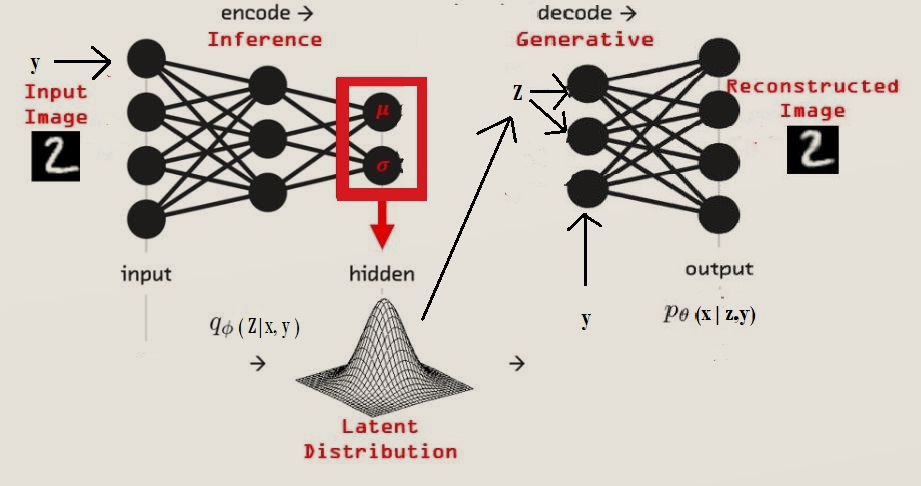

The objective of this mini-project is to define and train a Conditional VAE
(CVAE), by following the instructions below:


**Find resources that explain what a CVAE is, it’s difference with VAEs, the loss functions used to train it etc.**


 **Train a CVAE on the Fashion-MNIST dataset (available to download from
torchvision).**

**Generate 5 new samples for each class of the Fashion-MNIST dataset using
the CVAE.**

**Use Pytorch**

**Explain and argue the different choices you make along the way, in particular:**

  – The choice of the architecture, the layer types, the layer sizes and the
    activations.

  – The choice of the different hyper-parameters: batch size, learning rate,
    number of epochs, regularization weight...

  – The choice of the loss function, the different terms in it, and their
    individual purposes.

**Include links to articles, blog posts, videos... that helped you decide on theabove choices.**

**Include the code of the different trials/experiments that helped you decide
on the above choices.**

**Plot different visualizations for the results: the curves of the different terms in the loss functions, the learnt latent space...**



---



"*The CVAE is a conditional
directed graphical model whose input observations modulate the prior on Gaussian latent variables
that generate the outputs. It is trained to maximize the conditional log-likelihood, and we formulate
the variational learning objective of the CVAE in the framework of stochastic gradient variational
Bayes (SGVB) [16].* "

The Conditional Variational Autoencoder (CVAE) loss function is defined as:

$$
\mathcal{L}(x, y; \theta, \phi) = \mathbb{E}_{q_{\phi}(z|x,y)}[\log p_{\theta}(y|x,z)] - \text{KL}(q_{\phi}(z|x,y) \parallel p_{\theta}(z|x))
$$

Where:
- $x$ is the input data,
- $y$ is the conditional target data,
- $q_{\phi}(z|x,y)$ is the encoder (approximate posterior),
- $p_{\theta}(y|x,z)$ is the decoder (likelihood),
- $p_{\theta}(z|x)$ is the prior distribution,
- and $\text{KL}$ is the Kullback-Leibler divergence.


The following work is based on the practical work done during the HDDL course (in particular the vae notebook) but adding the conditional dimension. 

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [42]:
from torchvision import datasets, transforms
batch_size = 128

# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='../../data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='../../data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


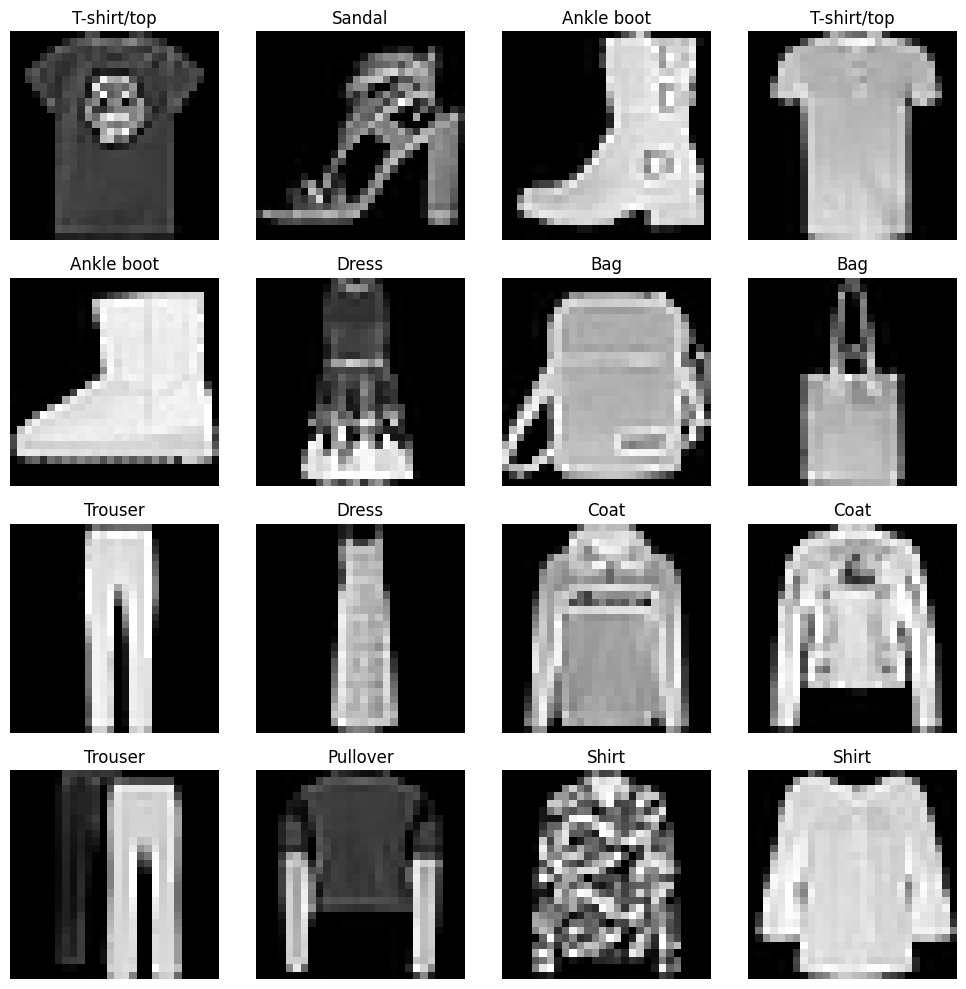

In [43]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

batch_size = 16  # You can adjust this size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Get one batch of images and labels
images, labels = next(iter(train_loader))

# Plot the batch of images
plt.figure(figsize=(10, 10))
for i in range(batch_size):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [91]:
class CVAE(nn.Module):
    def __init__(self, latent_dim=10, condition_dim=10 ):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.condition_dim = condition_dim #ADDED

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance, ADDING the conditional dimension to the input
        self.fc_mu = nn.Linear(128 * 4 * 4 + condition_dim, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4 + condition_dim, latent_dim)
        self.fc_decode = nn.Linear(latent_dim + condition_dim, 128 * 4 * 4)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )

        

    def encode(self, x, c ): # q(z|x, c)
        x = self.encoder(x)
        """ print("encode")
        print(np.shape(x))
        print(np.shape(c))  """
        x = x.view(-1, 128 * 4 * 4) # Flatten the output of the convolutional layers

        x = torch.cat([x, c], dim=1) # ADDED

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar 
    
    """ def encode(self, x, y):
        print("encode")
        print(np.shape(x))
        print(np.shape(y))
        xc = torch.cat([x.view(-1, 28*28), y], dim=1)
        hidden = self.encoder(xc)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        return mu, logvar
     """

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c ): # p(x|z, c)
        """ print("decode")
        print(np.shape(z))
        print(np.shape(c)) """
        z = torch.cat([z, c], dim=1) # ADDED

        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)  # Reshape to (128, 4, 4) for the decoder
        x = self.decoder(x)
        return x

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.sample(mu, logvar)
        return self.decode(z, c), mu, logvar

# CVAE loss function

In [102]:
# Implement the loss function
def loss_function_cvae(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD

# Train the CVAE

In [119]:
# Hyperparameters
latent_dim = 20
condition_dim = 10 ### 
learning_rate = 1e-3
epochs = 30 #30 
beta = 1

epoch_loss_list=[]

cvae = CVAE(latent_dim=latent_dim, condition_dim= condition_dim)
#print(cvae)
cvae.to(device)
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

# At the end of each epoch, print the training loss
for epoch in range(1, epochs + 1):
    cvae.train()
    running_loss = 0.0

    for batch_idx, (data, labels) in enumerate(train_loader):  # Assuming labels is the class label

        data = data.to(device)
        labels = labels.to(device)

        # Convert labels to one-hot encoding for the condition vector `c`
        c = F.one_hot(labels, num_classes=condition_dim).float()  # One-hot encoded condition vector

        optimizer.zero_grad()

        # print(np.shape(data))

        recon_batch, mu, logvar = cvae(data, c)

        loss,_,_ = loss_function_cvae(recon_batch, data, mu, logvar, beta) # using the CVAE loss function

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_loss_list.append(epoch_loss)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')

Epoch 1, Training loss: 254.9030
Epoch 2, Training loss: 243.3121
Epoch 3, Training loss: 240.7408
Epoch 4, Training loss: 239.3173
Epoch 5, Training loss: 238.4380
Epoch 6, Training loss: 237.7139
Epoch 7, Training loss: 237.2266
Epoch 8, Training loss: 236.7354
Epoch 9, Training loss: 236.4096
Epoch 10, Training loss: 236.1423
Epoch 11, Training loss: 235.9199
Epoch 12, Training loss: 235.6711
Epoch 13, Training loss: 235.5161
Epoch 14, Training loss: 235.2895
Epoch 15, Training loss: 235.1716
Epoch 16, Training loss: 235.0142
Epoch 17, Training loss: 234.9135
Epoch 18, Training loss: 234.7880
Epoch 19, Training loss: 234.6622
Epoch 20, Training loss: 234.5550
Epoch 21, Training loss: 234.4704


KeyboardInterrupt: 

# Visulaisation

Using the function provided from the course we can now plot the results.

In [ ]:
import matplotlib.pyplot as plt

def image_comparison(original_images, reconstructions, n_images=6):
    """Plots the original images and its reconstructions for comparison

    Args:
        original_image (torch.Tensor): The original images
        reconstructions (torch.Tensor): Reconstruction of the original images
    """
    fig, ax = plt.subplots(2, n_images, figsize=(10, 5))

    for i in range(n_images):
        # Plot original images
        ax[0, i].imshow(original_images[i], cmap='gray')
        ax[0, i].axis('off')
        ax[0, 0].set_title('Original')

        # Reconstructed images
        ax[1, i].imshow(reconstructions[i], cmap='gray')
        ax[1, i].axis('off')
        ax[1, 0].set_title('Recomstruction')

    plt.tight_layout()
    plt.show()

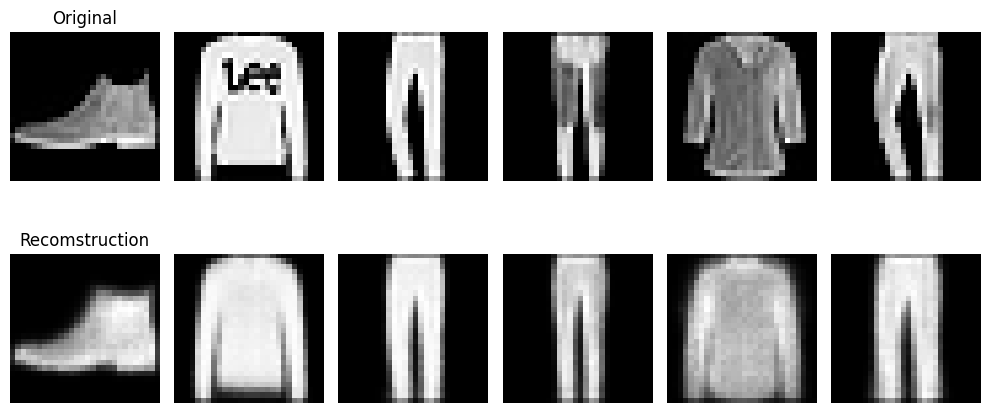

In [ ]:
# Select a batch of images from the test dataset
random_images, labels = next(iter(test_loader))

# One-hot encode the labels for the conditional input
c = F.one_hot(labels, num_classes=condition_dim).float().to(device)  # Convert labels to one-hot encoding

# Get the reconstructions of the selected images
recons, _, _ = cvae(random_images.to(device), c)  # Pass entire batch of images and conditional labels

# Reshape the images for plotting
random_images = random_images.cpu().numpy().squeeze()
recons = recons.detach().cpu().numpy().squeeze()

# Plot the original images and their reconstructions
image_comparison(random_images, recons)

## Visualizing the latent space


Training VAE with KL Weight = 1
Epoch 1: Average Loss: 253.4282, BCE: 238.9663, KLD: 14.4619
Epoch 2: Average Loss: 243.1742, BCE: 229.1502, KLD: 14.0240
Epoch 3: Average Loss: 240.7321, BCE: 226.8509, KLD: 13.8812
Epoch 4: Average Loss: 239.3076, BCE: 225.4934, KLD: 13.8142
Epoch 5: Average Loss: 238.3324, BCE: 224.5731, KLD: 13.7593


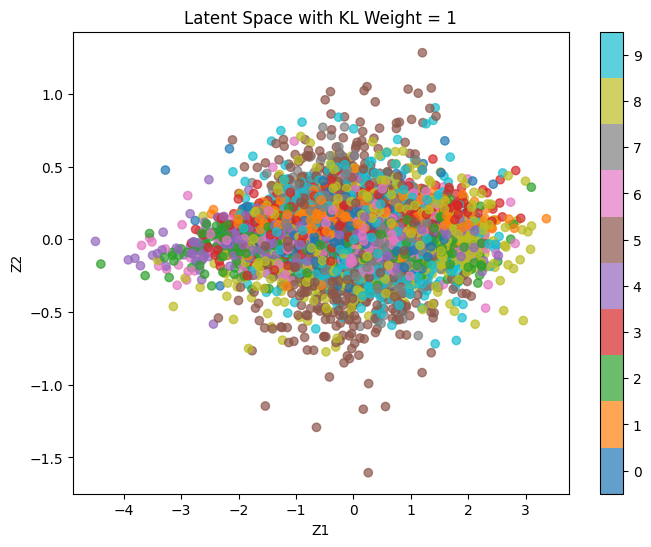


Training VAE with KL Weight = 10
Epoch 1: Average Loss: 253.9626, BCE: 239.5135, KLD: 14.4491
Epoch 2: Average Loss: 243.2710, BCE: 229.1768, KLD: 14.0941
Epoch 3: Average Loss: 240.7759, BCE: 226.8509, KLD: 13.9250
Epoch 4: Average Loss: 239.3660, BCE: 225.5183, KLD: 13.8478
Epoch 5: Average Loss: 238.4138, BCE: 224.5604, KLD: 13.8534


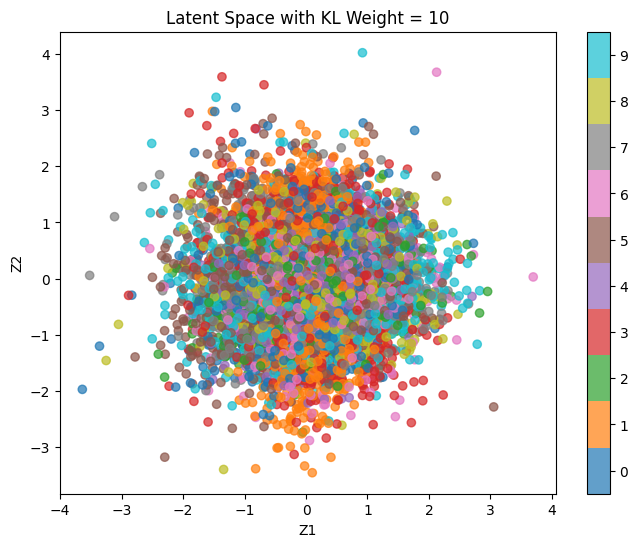


Training VAE with KL Weight = 100
Epoch 1: Average Loss: 254.8033, BCE: 240.6501, KLD: 14.1532
Epoch 2: Average Loss: 243.3260, BCE: 229.4227, KLD: 13.9033
Epoch 3: Average Loss: 240.8266, BCE: 227.0184, KLD: 13.8082
Epoch 4: Average Loss: 239.3619, BCE: 225.6214, KLD: 13.7406
Epoch 5: Average Loss: 238.4607, BCE: 224.7260, KLD: 13.7347


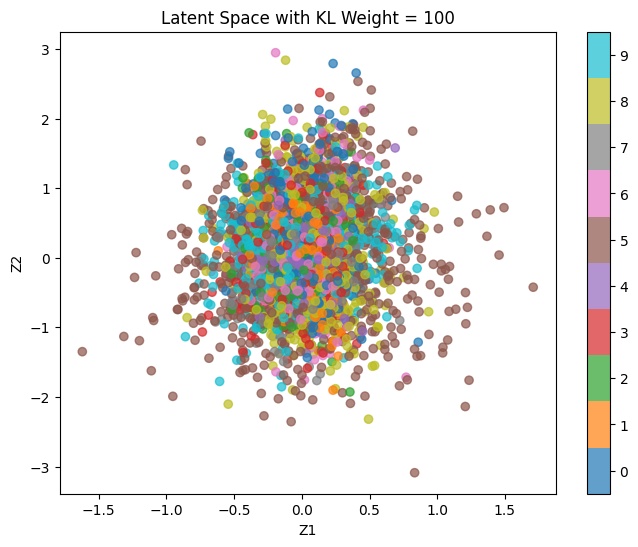

In [117]:
# Hyperparameters
latent_dims = 20
condition_dim = 10 ### 
batch_size = 128
num_epochs = 5 #10
learning_rate = 1e-3
kl_weights = [1, 10, 100]  # Different weights for the KL divergence term

# Training and plotting function
def train_and_plot(kl_weight):
    model = CVAE(latent_dims, condition_dim).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    train_losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        bce_loss = 0
        kld_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):  # Assuming labels is the class label

            data = data.to(device)
            labels = labels.to(device)

            # Convert labels to one-hot encoding for the condition vector `c`
            c = F.one_hot(labels, num_classes=condition_dim).float()  # One-hot encoded condition vector

            optimizer.zero_grad()

            # print(np.shape(data))

            recon_batch, mu, logvar = model(data, c)

            loss,bce,kld = loss_function_cvae(recon_batch, data, mu, logvar, beta) # using the CVAE loss function

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()
        
        average_loss = epoch_loss / len(train_loader.dataset)
        average_bce = bce_loss / len(train_loader.dataset)
        average_kld = kld_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}: Average Loss: {average_loss:.4f}, BCE: {average_bce:.4f}, KLD: {average_kld:.4f}')
    
    # Plot latent space
    plot_latent_space(model, kl_weight)

# Function to plot latent space
def plot_latent_space(model, kl_weight):
    model.eval()
    with torch.no_grad():
        test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
        data, labels = next(iter(test_loader))
        data = data.to(device)
        labels = labels.to(device)
        c = F.one_hot(labels, num_classes=condition_dim).float()  # One-hot encoded condition vector
        mu, logvar = model.encode(data,c)
        z = mu  # For visualization, we use the mean
        z = z.cpu().numpy()
        labels = labels.cpu().numpy()
        
        plt.figure(figsize=(8,6))
        scatter = plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10', alpha=0.7)
        plt.colorbar(scatter, ticks=range(10))
        plt.clim(-0.5, 9.5)
        plt.title(f'Latent Space with KL Weight = {kl_weight}')
        plt.xlabel('Z1')
        plt.ylabel('Z2')
        plt.show()

# Run training and plotting for different KL weights
for kl_weight in kl_weights:
    print(f'\nTraining VAE with KL Weight = {kl_weight}')
    train_and_plot(kl_weight)

# Generating 5 new samples

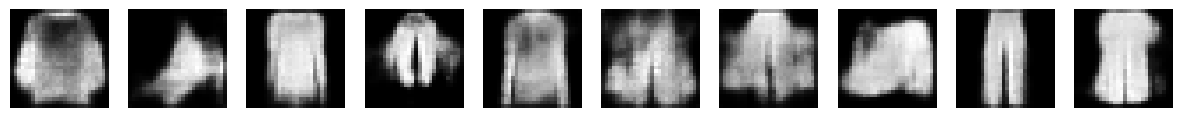

In [118]:
def generate_sample(num_samples=10):
    cvae.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)  # Sample random latent vectors

        random_labels = torch.randint(0, condition_dim, (num_samples,)).to(device)  # Random class labels
        c = F.one_hot(random_labels, num_classes=condition_dim).float().to(device)  # One-hot encode labels

        samples = cvae.decode(z,c) # Decode the latent vectors
        samples = samples.cpu().view(num_samples, 1, 28, 28) # Reshape the samples

        fig, ax = plt.subplots(1, num_samples, figsize=(15, 2))
        for i in range(num_samples):
            ax[i].imshow(samples[i].squeeze(0), cmap='gray')
            ax[i].axis('off')
        plt.show()

generate_sample()

Sources:

https://proceedings.neurips.cc/paper_files/paper/2015/file/8d55a249e6baa5c06772297520da2051-Paper.pdf

https://pyro.ai/examples/cvae.html